# CNNs: Building a CNNs from scratch

In [1]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
import torchvision.transforms as transforms
import time

In [2]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 1.1 MB/s eta 0:00:00


In [3]:
from ignite.handlers import FastaiLRFinder
from ignite.engine import create_supervised_trainer

## Inspect the Flowers102 dataset

In [4]:
dataset = torchvision.datasets.Flowers102('data/', download=True, split='train')

100%|██████████| 344862509/344862509 [00:16<00:00, 21185288.86it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 444300.61it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9408623.56it/s]


In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=754x500>, 0)

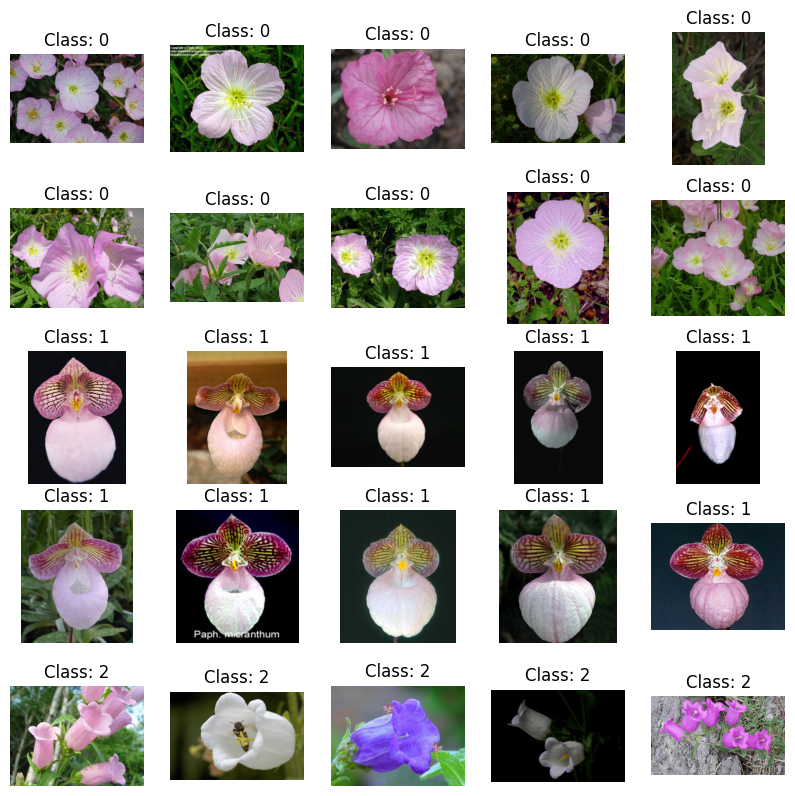

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
  ax[i//5, i%5].imshow(dataset[i][0])
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_title(f'Class: {dataset[i][1]}')
plt.show()

In [ ]:
label_count = dict()
for img, label in dataset:
  label_count[label] = label_count.get(label, 0) + 1

In [ ]:
print('Number of classes')
len(label_count.keys())

Number of classes


102

## Image classification with AlexNet

In order to get a better understanding how CNNs work, we will build and train a neural network from scratch. As base architecture will will use the AlexNet.

Introduced in 2012, AlexNet stands as a cornerstone in deep learning, ushering in a new era in image recognition with its convolutional neural network (CNN) architecture. Although there are superior architecture nowadays, being easy to implement, it's a good starting point for getting an understanding how CNNs work.

In [6]:
DEVICE = 'cuda'
BATCH_SIZE = 64

### Helper functions

In [ ]:
def plot_accuracy(stats, title=None):

  epochs = [item['epoch'] for item in stats]
  train_accs = [item['train_acc'] for item in stats]
  val_accs = [item['val_acc'] for item in stats]

  plt.plot(epochs, train_accs, label='Train Acc')
  plt.plot(epochs, val_accs, label=f'Val Acc [Best: {max(val_accs):.2f}%]')
  plt.legend()

  if title:
    plt.title(title)

In [ ]:
def train(model, train_loader, optimizer, criterion, num_epochs, val_loader=None):

  '''
  Trains the model on the dataloader for a given number of epochs
   '''

  print('===== Start training ===== \n')

  model.train()

  start = time.time()

  stats = []

  for epoch in range(1, num_epochs+1):

    epoch_loss = 0

    for x, y in train_loader:

      optimizer.zero_grad()

      x = x.to(DEVICE)
      y = y.to(DEVICE)

      y_pred = model(x)

      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f'[{epoch}] Loss: {epoch_loss:.3f}')

    if epoch % 5 == 0:
      train_acc = eval_accuracy(model, train_loader)
      if val_loader:
        val_acc = eval_accuracy(model, val_loader)
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%  /  Val Acc: {val_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc, 'val_acc': val_acc})
      else:
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc})


  end = time.time()
  elapsed_time = end - start

  print()
  print('===== Finished training ===== ')
  print(f'Elapsed time in minutes: {elapsed_time/60:.2f}')

  return stats

In [ ]:
def eval_accuracy(model, loader):

    '''
    Measure the accuracy of the given model on the provided dataloader
    '''

    epoch_acc = 0

    model.eval()

    num_corr_pred = 0
    num_total_pred = 0

    with torch.no_grad():

        for x, y in loader:

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)

            top_pred = y_pred.argmax(1)
            num_corr_pred += (top_pred == y).sum()
            num_total_pred += len(y)

    acc = num_corr_pred / num_total_pred * 100

    return acc.item()

### Implementing AlexNet from scratch

AlexNet comprises five convolutional layers. These layers are responsible for extracting various features from the input images. For the following explaination we asssume an input image of size 224x224.

**Feature Extractor:**
- Convolution [F=96, K=11x11, S=4, P=2] => 96x55x55
- Max Pool [K=3x3, S=2, P=0] => 96x27x27
- Convolution [F=192, K=5x5, S=1, P=2] => 192x27x27
- Max Pool [K=3x3, S=2, P=0] => 192x13x13
- Convolution [F=384, K=3x3, S=1, P=1] => 384x13x13
- Convolution [F=256, K=3x3, S=1, P=1] => 256x13x13
- Convolution [F=256, K=3x3, S=1, P=1] => 256x13x13
- Max Pool [K=3x3, S=2, P=0] => 256x6x6

**Classification Head:**
- Linear Layer [256*6*6=9216,4096]
- Linear Layer [4096,4096]
- Linear Layer [4096,102]

**Hint:**

Formula to calculate the output size of a convolutional layer:

$O = \lfloor\frac{I-K+2P}{S}\rfloor +1$

Formula to calculate the output size of a pooling layer:

$O = \lfloor\frac{I-K+2P}{S}\rfloor +1$


In [59]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        # Apply the default weight initalization
        self.reset_parameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        print(x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def reset_parameters(self):
       self.apply(self._initialize_parameters)

    def _initialize_parameters(self, m):
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)


In [60]:
model = AlexNet(102)
model = model.to(DEVICE)

In [61]:
model(torch.randn((1, 3, 224, 224)).to(DEVICE))

torch.Size([1, 256, 6, 6])


tensor([[-18.7839,  -3.4110, -22.3466,  24.0938, -34.8814, -20.5587, -12.3255,
          25.4682,  42.4915,  13.2077, -19.9007,  -3.4344, -18.3709, -19.2278,
          37.2541, -47.5218,  38.1843,  10.3744,  -3.8897,  -6.8765, -15.9625,
          21.0849,   0.1955,  10.6072,  38.9491,   1.4538,   0.7156,  -0.6160,
           8.7005, -26.8839,   0.3633, -37.1677,   2.8863, -53.8127,  41.9006,
           1.3262,  -2.4499, -15.0660,   1.6915,   5.3988,  22.1564,  18.5224,
         -18.1967,  -5.4182,  31.1586, -11.6635,   9.2410,  28.3486,  23.4222,
         -55.6578,   4.5749,  -5.0038, -18.3822,  11.8950,   1.2813, -16.8538,
           1.9133,   7.5986,  36.0061,   0.5266,  -8.5661,  15.6725, -11.5124,
         -16.5418,  -6.5933, -39.2133, -34.2454,  -1.6139,   0.4750,   6.9628,
           7.1543,  -6.1744,  -1.0817,  -1.5073,   4.1423,  16.1199, -20.7323,
          -9.1092,   6.8213,  -7.2145,   8.0311,   0.6921,  -5.6317,  13.5383,
          30.4281,  16.8488,  14.2387,  45.3118,  14

### Prepare the train, val and test set

In [ ]:
train_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=0.5, std=0.5)
])

test_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=0.5, std=0.5)
])

train_dataset = torchvision.datasets.Flowers102('data/', download=True, split='train', transform=train_transforms)
val_dataset = torchvision.datasets.Flowers102('data/', download=True, split='val', transform=test_transforms)
test_dataset = torchvision.datasets.Flowers102('data/', download=True, split='test', transform=test_transforms)

In [ ]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

### Learning rate range test to estimate a good initial learning rate

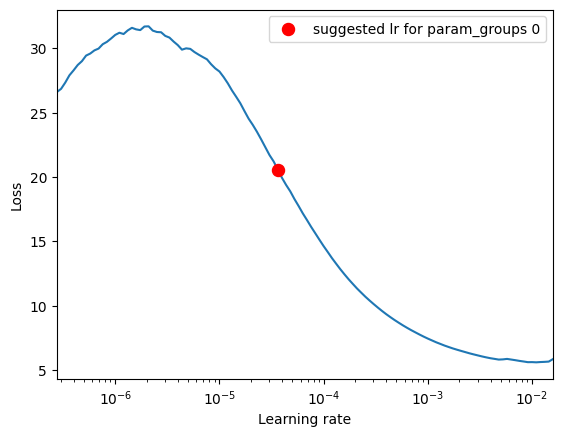

3.630780547701014e-05

In [ ]:
start_lr = 1e-7
end_lr = 1e+1
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainer = create_supervised_trainer(model, optimizer, criterion, DEVICE)

lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save, start_lr=start_lr, end_lr=end_lr, num_iter=200) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

# Get lr_finder results
lr_finder.get_results()

# Plot lr_finder results (requires matplotlib)
lr_finder.plot()

# get lr_finder suggestion for lr
lr_finder.lr_suggestion()

### Train the model (without augmentation)

In [ ]:
model.reset_parameters()

In [ ]:
num_epochs = 100

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
stats = train(model, train_loader, optimizer, criterion, num_epochs, val_loader)

===== Start training ===== 

[1] Loss: 136.956
[2] Loss: 79.315
[3] Loss: 74.440
[4] Loss: 71.642
[5] Loss: 69.437
[5] Train Acc: 19.71%  /  Val Acc: 9.90%
[6] Loss: 61.559
[7] Loss: 51.532
[8] Loss: 39.909
[9] Loss: 30.318
[10] Loss: 22.090
[10] Train Acc: 85.00%  /  Val Acc: 25.59%
[11] Loss: 14.503
[12] Loss: 9.643
[13] Loss: 4.963
[14] Loss: 2.414
[15] Loss: 1.432
[15] Train Acc: 100.00%  /  Val Acc: 30.39%
[16] Loss: 0.797
[17] Loss: 0.431
[18] Loss: 0.221
[19] Loss: 0.148
[20] Loss: 0.117
[20] Train Acc: 100.00%  /  Val Acc: 32.65%
[21] Loss: 0.099
[22] Loss: 0.088
[23] Loss: 0.078
[24] Loss: 0.071
[25] Loss: 0.065
[25] Train Acc: 100.00%  /  Val Acc: 31.86%
[26] Loss: 0.060
[27] Loss: 0.055
[28] Loss: 0.051
[29] Loss: 0.048
[30] Loss: 0.044
[30] Train Acc: 100.00%  /  Val Acc: 31.76%
[31] Loss: 0.042
[32] Loss: 0.039
[33] Loss: 0.037
[34] Loss: 0.035
[35] Loss: 0.033
[35] Train Acc: 100.00%  /  Val Acc: 32.35%
[36] Loss: 0.031
[37] Loss: 0.030
[38] Loss: 0.028
[39] Loss: 0.027
[

### Plot accuracy

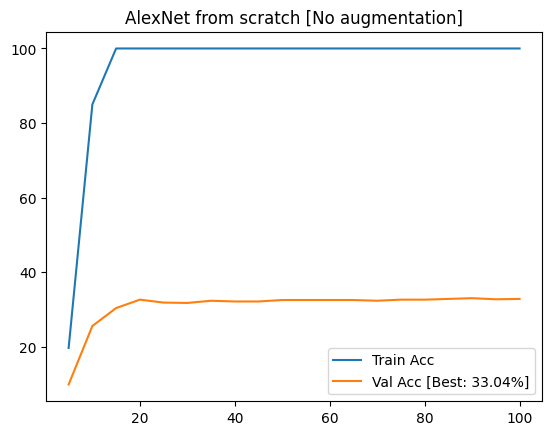

In [ ]:
plot_accuracy(stats, title='AlexNet from scratch [No augmentation]')

In [ ]:
test_acc = eval_accuracy(model, test_loader)
print(f'Accuracy on the test set (final model): {test_acc:.2f}%')

Accuracy on the test set (final model): 28.20%


## Training AlexNet with augmentation

### Enable augmentation

In [ ]:
train_transforms = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize(256),
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=0.5, std=0.5)
])

train_dataset = torchvision.datasets.Flowers102('data/', download=True, split='train', transform=train_transforms)

In [ ]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

### Training the model

In [ ]:
model.reset_parameters()

In [ ]:
num_epochs = 200

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
stats = train(model, train_loader, optimizer, criterion, num_epochs, val_loader)

===== Start training ===== 

[1] Loss: 111.881
[2] Loss: 77.932
[3] Loss: 75.218
[4] Loss: 73.673
[5] Loss: 72.377
[5] Train Acc: 6.47%  /  Val Acc: 5.98%
[6] Loss: 68.308
[7] Loss: 64.131
[8] Loss: 59.929
[9] Loss: 57.534
[10] Loss: 55.476
[10] Train Acc: 20.39%  /  Val Acc: 16.57%
[11] Loss: 52.559
[12] Loss: 50.643
[13] Loss: 47.963
[14] Loss: 47.637
[15] Loss: 46.417
[15] Train Acc: 28.24%  /  Val Acc: 23.14%
[16] Loss: 44.747
[17] Loss: 43.189
[18] Loss: 42.105
[19] Loss: 39.604
[20] Loss: 38.198
[20] Train Acc: 38.82%  /  Val Acc: 32.35%
[21] Loss: 39.011
[22] Loss: 36.821
[23] Loss: 36.373
[24] Loss: 35.616
[25] Loss: 33.848
[25] Train Acc: 47.55%  /  Val Acc: 31.27%
[26] Loss: 32.462
[27] Loss: 32.010
[28] Loss: 31.175
[29] Loss: 29.935
[30] Loss: 30.274
[30] Train Acc: 53.73%  /  Val Acc: 36.18%
[31] Loss: 29.156
[32] Loss: 25.821
[33] Loss: 26.227
[34] Loss: 26.596
[35] Loss: 26.192
[35] Train Acc: 59.80%  /  Val Acc: 36.18%
[36] Loss: 25.085
[37] Loss: 24.956
[38] Loss: 23.4

### Plot accuracy

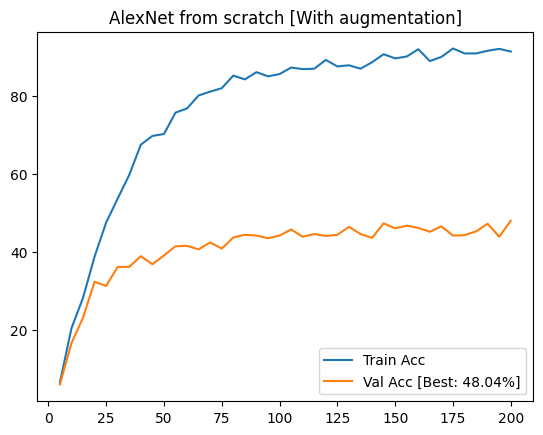

In [ ]:
plot_accuracy(stats, title='AlexNet from scratch [With augmentation]')

In [ ]:
test_acc = eval_accuracy(model, test_loader)
print(f'Accuracy on the test set (final model): {test_acc:.2f}%')

Accuracy on the test set (final model): 40.84%
